In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

import sys
sys.path.append('../mchem_functions')
import PCA_functions as pcf
import multivariate_functions as mvf

In [2]:
chosen_PCs = [1,2]
no_of_components = 5

scaling_method = 'SNV'

nmr_data_dir = '../../Data/NMR'
nmr_data_arc = 'nmr_archive'

In [3]:
try: os.chdir(nmr_data_dir)
except FileNotFoundError: pass

In [4]:
sites_long_names = {
    'HM': 'Hare Moss',
    'AM': 'Auchencorth Moss'
}

def get_attr(s:str):
    s = s.replace('MP-','').replace('PW-','')
    sample_name = s
    s = s.split('-')
    site = s[0]
    sitelong = sites_long_names[site]
    season = s[-2]
    replicate = s[-1]

    return sample_name,site,sitelong,season,replicate

In [5]:
path = f"{nmr_data_arc}\\*\\11\\pdata\\*\\integrals.txt"
integral_files = glob.glob(path)
integrals_list = []
attribute_list = []

for file in integral_files:

    # make sure all -'s are separated with at least one space
    with open(file, 'r') as f:
        filedata = f.read()
    filedata = filedata.replace('-', ' -')
    with open(file, 'w') as f:
        f.write(filedata)
    f.close()

    int_df = pd.read_csv(file,skiprows=4,sep=r"\s+")
    integrals_list.append(int_df['Integral'].to_numpy())
    attribute_list.append([*get_attr(file.split('\\')[1])])

    if len(integrals_list[-1]) == 0:
        print(attribute_list[-1])

ppm = np.mean(int_df[['Integrated','Region']].to_numpy(),axis=1)

attribute_array = np.array(attribute_list)
integrals_arr = np.array(integrals_list)
no_of_spectra = len(integrals_arr)

In [6]:
row_sum = np.sum(integrals_arr,axis=1)
integrals_arr = integrals_arr / np.reshape(row_sum,(len(row_sum),1))

In [7]:
# set regions to exclude and exclude them
regions_to_exclude = [[np.min(ppm),0.5],
                      [1.92,2],
                      [4.5,5.07],                  
                      [8.4,np.max(ppm)]] # 8.4,9

idx_to_exclude = []
for r in regions_to_exclude:
    idx_to_exclude += [*np.where((ppm>=np.min(r))&(ppm<=np.max(r)))[0]]
idx_to_exclude = np.array(idx_to_exclude)
idx_to_include = np.array([x for x in np.arange(len(ppm)) if x not in idx_to_exclude])
ppm = ppm[idx_to_include]
integrals_arr = integrals_arr[:,idx_to_include]

In [8]:
snv = mvf.SNV(integrals_arr)

In [9]:
regions = {
    'alkyl': (0, 2),
    'functionalised alkyls': (2, 3),
    'O-alkyl': (3, 5.5),
    'alkene': (5, 6.5),
    'aromatics': (6, 8),
    'aldehydes': (8, 9)
}
sites = np.unique(attribute_array[:,1])
seas_uniq = np.unique(attribute_array[:,3])
siteslong = {
    'HM': 'Hare Moss',
    'AM': 'Auchencorth Moss'
}

In [10]:
reg_int_list = []
for integr in integrals_arr:
    
    reg_int_list += [[np.sum(integr[np.where((ppm > np.min(regions[r])) & (ppm <= np.max(regions[r])))]) for r in regions]]

In [11]:
def boxplot_anova(df_phys:pd.DataFrame,costant,costant_col,level_col,variable,ax:plt.Axes=None,title:str=None,
                  ylabel:str=None,xlabel:str=None,titlesize:float|int=16,labelsize:float|int=11,showmeans=False,
                  colours=[],marker='o',**kwargs):
    
    if ax == None:
        fig, ax = plt.subplots()
    
    level_unique = np.unique(df_phys[level_col].to_numpy())

    x = [df_phys[(df_phys[level_col]==l)&(df_phys[costant_col]==costant)][variable].dropna().to_numpy() for l in level_unique]

    bplot = ax.boxplot(x,tick_labels=level_unique,showmeans=showmeans,meanline=showmeans,medianprops=dict(color='k',ls='-'),
                       showfliers=False,patch_artist=True,**kwargs)
    
    if type(colours)!=list: colours=[colours]
    if colours != []:
        if len(bplot['boxes']) ==  len(colours):
            for patch, colour in zip(bplot['boxes'], colours):
                patch.set_facecolor(colour)
        else:
            for patch in bplot['boxes']:
                patch.set_facecolor(colours[0])

    for i in range(len(x)):
        if type(marker) != list: m = marker
        else: m = marker[i]
        ax.scatter([i+1]*len(x[i]),x[i],zorder=2,alpha=.5,marker=m,facecolors='none',edgecolors='k')

    if xlabel == None: xlabel = level_col
    ax.set_xlabel(xlabel,fontsize=labelsize)
    if ylabel == None: ylabel = variable
    ax.set_ylabel(ylabel,fontsize=labelsize)
    
    if title != None: ax.set_title(title,fontsize=titlesize)

    p_dict = {}
    for comb in list(combinations(range(len(x)),2)):
        p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]

    p_rounding = 4
    p_str = '\n'.join([f'$p_{{{key}}}$ = {np.round(p_dict[key],p_rounding)}' for key in p_dict])
    ax.text(.91,.885,p_str,ha='left',va='top',transform=plt.gcf().transFigure)

In [12]:
int_df = pd.DataFrame(reg_int_list,index=attribute_array[:,0],columns=regions.keys())
int_df['site'] = attribute_array[:,1]
int_df['season'] = attribute_array[:,3]
# int_df

In [13]:
m_shape = {'HM': 'o','AM': 's',}
sitesshort = {'Auchencorth Moss':'AM', 'Hare Moss':'HM'}
seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

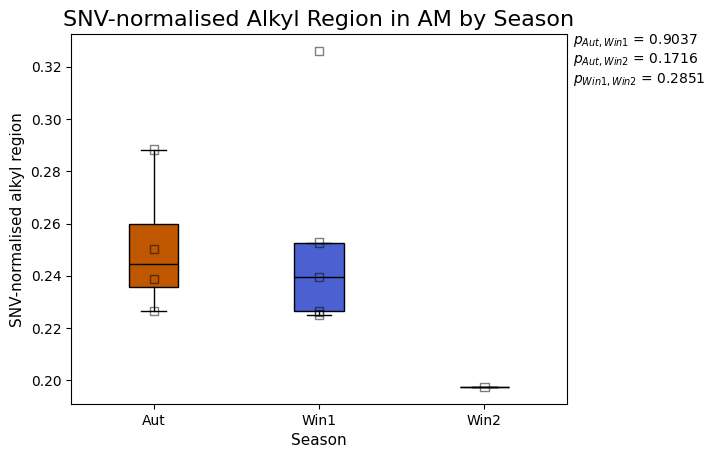

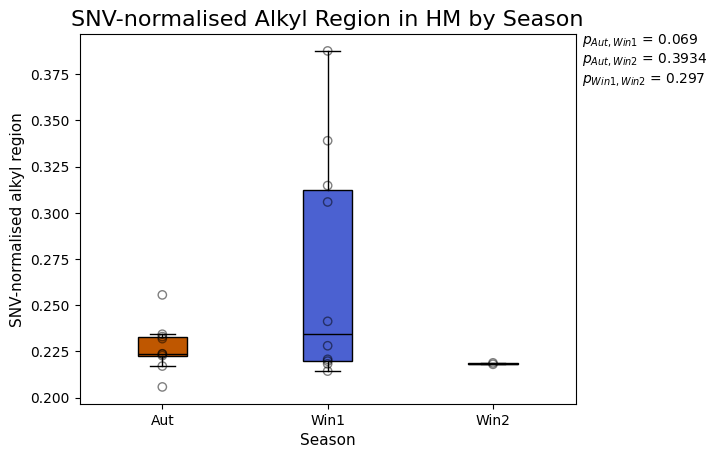

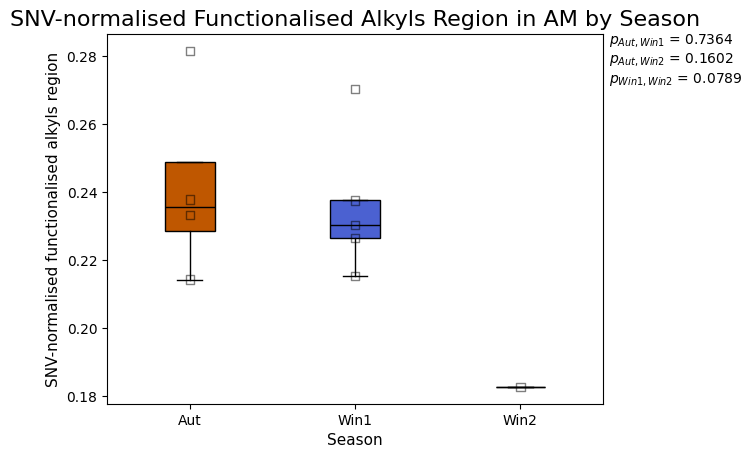

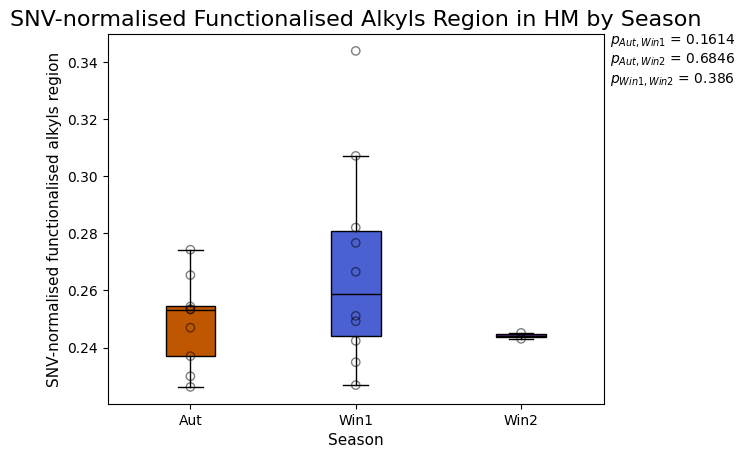

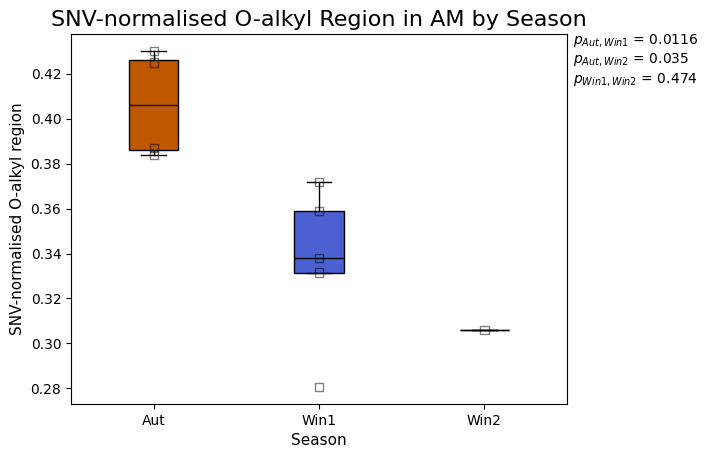

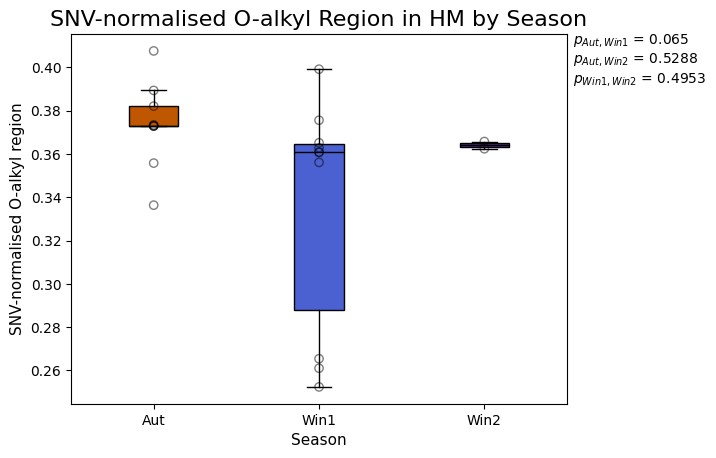

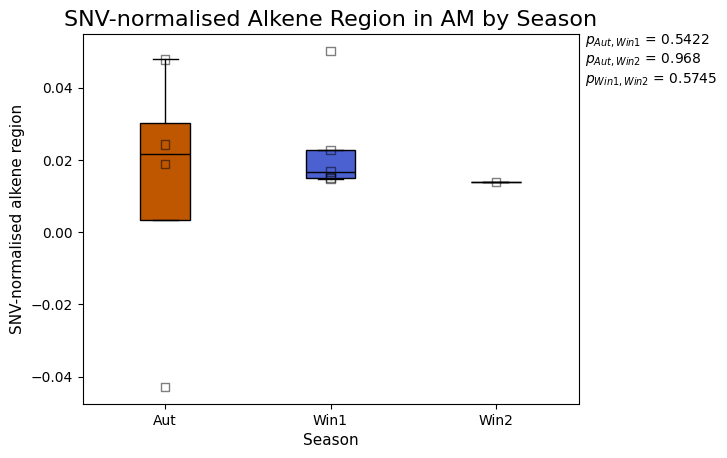

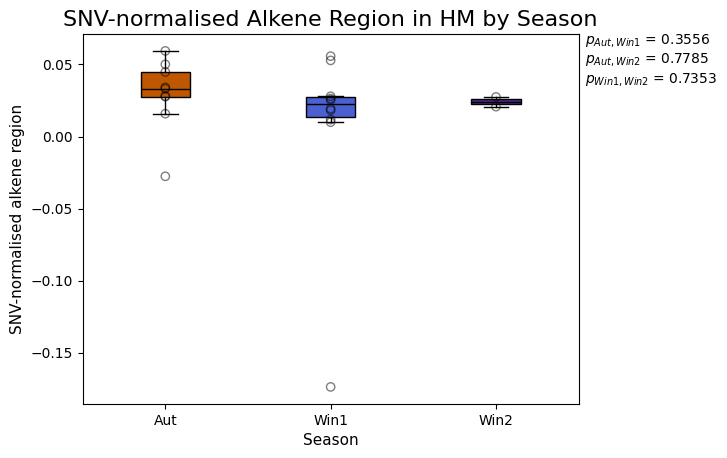

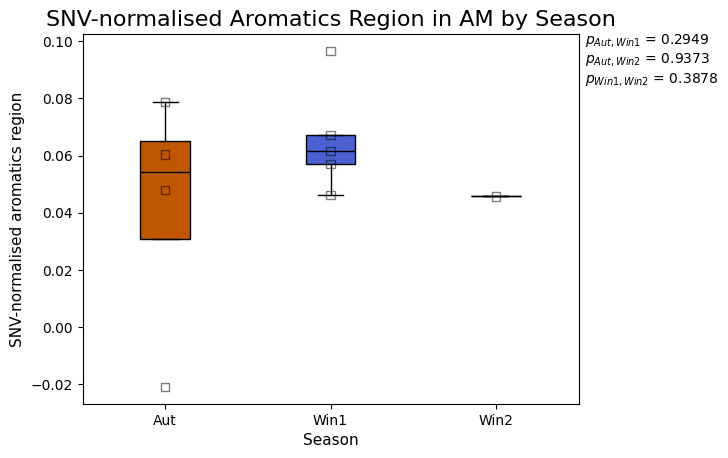

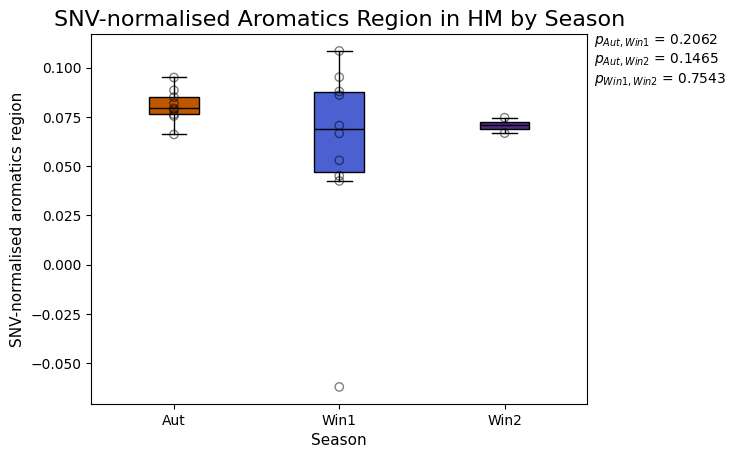

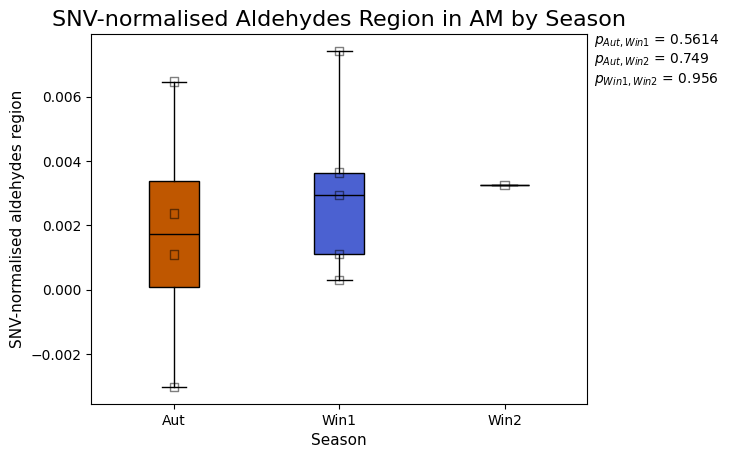

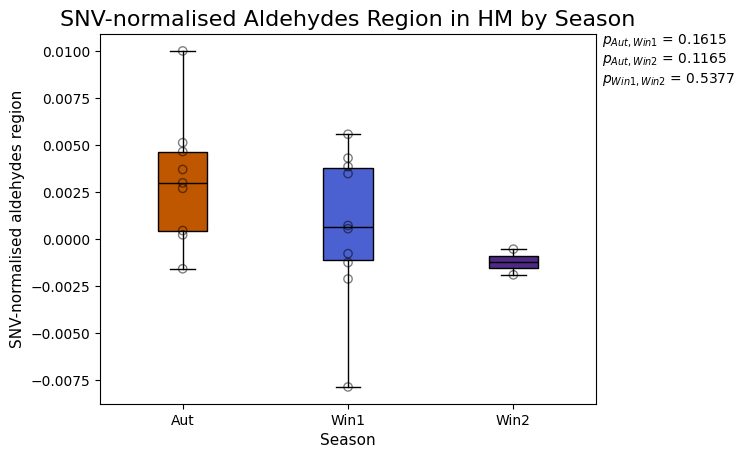

In [14]:
for r in regions.keys():
    for s in sites:
        fig_box, ax_box = plt.subplots()
        ylabel = f'SNV-normalised {r} region'
        boxplot_anova(int_df,s,'site','season',r,ax=ax_box,ylabel=ylabel,xlabel='Season',
                      title=f'{' '.join(y.capitalize() for y in ylabel.split(' ')).replace('Snv','SNV')} in {s} by Season',
                      colours=[seasonal_colours[s] for s in seas_uniq],marker=m_shape[s])
        fig_box.savefig(f'plots/anova_plots/by_season/{s.replace(' ','_')}_{ylabel.replace(' ','_').replace('/','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')
        
        # for i in range(len(df_metadata)):
        #     ax_box.scatter([i+1]*len(df_metadata[i]),df_metadata[i],zorder=-2,alpha=.5)